In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys, os
import h5py
sys.path.append('../')
import analysis_utils as utils
utils.load_plotting_setting()

from matplotlib.ticker import LogLocator, NullFormatter, MultipleLocator
yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']

from scipy.signal import savgol_filter, medfilt
from scipy.optimize import minimize

# import importlib
# importlib.reload(utils)

In [ ]:
def load_sphere_data(sphere='sphere_20250103'):

    data_dir = '/home/yt388/microspheres/dm_nanospheres/data_processed'

    file = f'{data_dir}/sphere_data/{sphere}_recon_all.h5py'
    with h5py.File(file, 'r') as fout:
        g = fout['recon_data_all']
        hist = g['hist'][:]
        n_window = g['hist'].attrs['n_windows']
        scaling = g['hist'].attrs['scaling']

        rate_all = g['rate_hist'][:]
        rate_all_err = g['rate_hist_err'][:]
        bc = g['bc'][:]

        time_all = g.attrs['time_hours']
        fout.close()

    file = f'{data_dir}/sphere_data/{sphere}_calibration_all.h5py'
    with h5py.File(file, 'r') as fout:
        g = fout['calibration_data_processed']
        eff_coefs = g['sig_efficiency_fit_params'][:]
        fout.close()

In [ ]:
from scipy.special import erf, zeta

def func2(x, z, f):
    return 0.5 * erf((x - z) * f) + 0.5

def gaus(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-1 * (x - mu)**2 / (2 * sigma**2))

def crystal_ball_rev(x, alpha, n, mu, sigma):
    # Modified from https://arxiv.org/pdf/1603.08591
    # and https://en.wikipedia.org/wiki/Crystal_Ball_function

    x = np.asarray(x)
    ret = np.empty_like(x)

    A = np.power(n / np.abs(alpha), n) * np.exp(-1 * alpha**2 / 2)
    B = n / np.abs(alpha) - np.abs(alpha)

    # Flip the direction to get the tail on the positive side
    idx_gaus = ((x - mu) / sigma) < alpha
    idx_other = ((x - mu) / sigma) > alpha

    # Flip `B - ...` to `B + ...` to reverse the power law tail 
    ret[idx_gaus] = np.exp(-1 * (x[idx_gaus] - mu)**2 / (2 * sigma**2))
    ret[idx_other] = A * np.power((B + (x[idx_other] - mu) / sigma), (-1 * n))

    return ret

def crystal_ball_rev_normalized(x, alpha, n, mu, sigma):
    xx = np.linspace(0, 50000, 5000)
    func_val = crystal_ball_rev(xx, alpha, n, mu, sigma)
    norm = np.trapz(func_val, xx)

    x = np.asarray(x)
    if x.size == 1:
        return crystal_ball_rev(x, alpha, n, mu, sigma)[0] / norm
    else:
        return crystal_ball_rev(x, alpha, n, mu, sigma) / norm

def expo_corrected(x, cutoff, xi):
    # Re-normalize exponential after applying efficiency correction 
    # and truncate from below
    xx = np.linspace(0, 50000, 5000)

    expo_eff_truncated = np.exp(-1 * (xx) / xi) / xi
    expo_eff_truncated[xx < cutoff] = 0

    expo_corrected_norm = np.trapz(expo_eff_truncated, xx)

    x = np.asarray(x)
    ret = np.exp(-1 * (x) / xi) / xi
    ret[x < cutoff] = 0

    if ret.size == 1:
        return ret[0] / expo_corrected_norm
    else:
        return ret / expo_corrected_norm

In [ ]:
def get_mui(a, alpha, n, mu, sigma, cutoff, xi, bi, ntot):
    # Use only the central value of pdf
    # faster and avoid numerical issues from integration
    joint_pdf = a * crystal_ball_rev_normalized(bi, alpha, n, mu, sigma) + (1 - a) * expo_corrected(bi, cutoff, xi)
    mui = ntot * joint_pdf * 50

    return mui

def nll(a, alpha, n, mu, sigma, cutoff, xi, bc, hist):
    idx = bc > 1000
    bi = bc[idx]
    ni = hist[idx]

    # Total number of count in the entire range
    ntot = np.sum(hist)

    mui = get_mui(a, alpha, n, mu, sigma, cutoff, xi, bi, ntot)
    return np.sum(np.nan_to_num(mui - ni * np.log(mui)))


In [ ]:
def plot_likelihood_fit(bc, hist, res_x):
    fig, axes = plt.subplots(2, 1, figsize=(7, 8), height_ratios=[4, 1])
    ana_threshold = 1000

    idx = bc > ana_threshold
    bi = bc[idx]
    ntot = np.sum(hist)

    hist_norm = n_window * scaling

    hist_fit_ml = get_mui(*res_x, bi, ntot)
    a, alpha, n, mu, sigma, cutoff, xi = res_x

    ax = axes[0]
    ax.fill_betweenx(np.logspace(-1, 9, 100), 0, ana_threshold, color='#B0C4DE', alpha=0.5)

    ax.errorbar(bi, hist[idx], yerr=np.sqrt(hist[idx]), fmt='.', color='#005AB5', alpha=1)
    ax.plot(bi, hist_fit_ml, '--', color='#DC143C', label='Reversed Crystal Ball + exponential (ML)')

    xx2 = np.linspace(1020, 10000, 500)
    crystal_ball_hist = ntot * 50 * a * crystal_ball_rev_normalized(xx2, alpha, n, mu, sigma)
    ax.fill_between(xx2, 0, crystal_ball_hist, color='#E1BE6A', alpha=0.25)

    xx1 = np.linspace(cutoff, 10000, 500)
    expo_hist = ntot * 50 * (1 - a) * expo_corrected(xx1, cutoff, xi)
    ax.fill_between(xx1, 0, expo_hist, color='#2E8B57', alpha=0.2)

    ax.set_yscale('log')
    ax.set_xlim(0, 8000)
    ax.set_ylim(1e-1, 1e9)

    ax.set_yticks(np.logspace(-1, 9, 11))
    locmin = LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=15)
    ax.xaxis.set_minor_locator(MultipleLocator(500))
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(NullFormatter())

    ax.legend(frameon=False)
    ax.set_xticklabels([''])
    ax.set_ylabel('Counts / (50 keV/c)')

    ax = axes[1]
    ax.plot(bc[idx], (hist[idx] - hist_fit_ml) / np.sqrt(hist[idx]), '.', color='#005AB5', markersize=5, label='Gaussian + exponential (ML)')
    ax.fill_betweenx(np.linspace(-1000, 1000, 100), 0, ana_threshold, color='#B0C4DE', alpha=0.5)

    ax.set_xlim(0, 8000)
    ax.set_ylim(-150, 150)
    ax.xaxis.set_minor_locator(MultipleLocator(500))
    ax.set_xlabel('Reconstructed amplitude (keV/c)')
    ax.set_ylabel('Residual ($\sigma_{\mathrm{stat}}$)')

    fig.suptitle('Sphere 20250103')
    fig.tight_layout()

    return fig, axes

/tmp/tmp.CFg4XolE8e/ipykernel_2490745/164037734.py:8: RuntimeWarning: overflow encountered in power
  A = np.power(n / np.abs(alpha), n) * np.exp(-1 * alpha**2 / 2)
/tmp/tmp.CFg4XolE8e/ipykernel_2490745/164037734.py:17: RuntimeWarning: invalid value encountered in multiply
  ret[idx_other] = A * np.power((B + (x[idx_other] - mu) / sigma), (-1 * n))
/tmp/tmp.CFg4XolE8e/ipykernel_2490745/1597628168.py:18: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.nan_to_num(mui - ni * np.log(mui)))
/tmp/tmp.CFg4XolE8e/ipykernel_2490745/1597628168.py:18: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.nan_to_num(mui - ni * np.log(mui)))


Optimization terminated successfully.
         Current function value: -152178767.020342
         Iterations: 543
         Function evaluations: 1076
[9.99996691e-01 3.47276505e+00 1.79826515e+02 6.07498287e-05
 2.88315297e+02 1.43813146e+03 2.46167781e+02]


/tmp/tmp.CFg4XolE8e/ipykernel_2490745/4214219789.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])
/tmp/tmp.CFg4XolE8e/ipykernel_2490745/4214219789.py:43: RuntimeWarning: divide by zero encountered in divide
  ax.plot(bc[idx], (hist[idx] - hist_fit_ml) / np.sqrt(hist[idx]), '.', color='#005AB5', markersize=5, label='Gaussian + exponential (ML)')


(<Figure size 700x800 with 2 Axes>,
 array([<Axes: ylabel='Counts / (50 keV/c)'>,
        <Axes: xlabel='Reconstructed amplitude (keV/c)', ylabel='Residual ($\\sigma_{\\mathrm{stat}}$)'>],
       dtype=object))

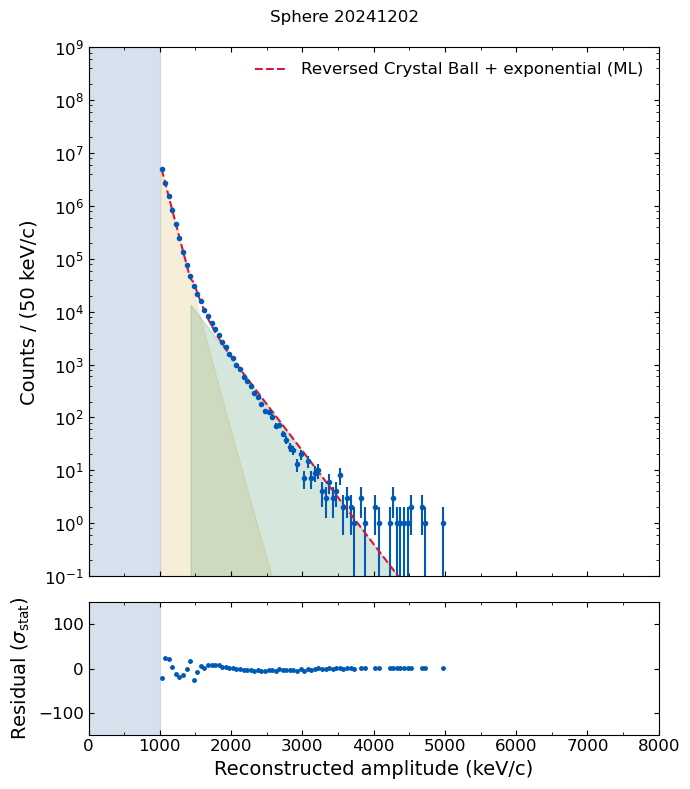

In [ ]:
ntot = np.sum(hist)
args = (bc, hist)

res = minimize(fun=lambda x: nll(*x, *args), 
               method='Nelder-Mead',
               x0 = [9.99996691e-01, 3.47276550e+00, 1.79826520e+02, 5.90524207e-05, 2.88315304e+02, 1440, 240],
               bounds = [(0.9999, 1), (2, 10), (0, 300), (0, 100), (200, 300), (1200, 1800), (100, 300)],
               options={'disp' : True,
                        'maxiter': 10000,
                        'maxfev': 10000,
                        'adaptive': True,
                        'fatol': 0.0001,
                        }
               )

param_nodm = res.x
nll_nodm   = res.fun

print(res.x)
plot_likelihood_fit(bc, hist, res.x)

Optimization terminated successfully.
         Current function value: -325398931.400860
         Iterations: 456
         Function evaluations: 960
[9.99999963e-01 3.88844938e+00 1.88930977e+01 1.64962666e+02
 2.55454974e+02 1.70317112e+03 3.73851449e+02]


/tmp/tmp.QiM92FqWUV/ipykernel_1378461/974970523.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])
/tmp/tmp.QiM92FqWUV/ipykernel_1378461/974970523.py:43: RuntimeWarning: divide by zero encountered in divide
  ax.plot(bc[idx], (hist[idx] - hist_fit_ml) / np.sqrt(hist[idx]), '.', color='#005AB5', markersize=5, label='Gaussian + exponential (ML)')


(<Figure size 700x800 with 2 Axes>,
 array([<Axes: ylabel='Counts / (50 keV/c)'>,
        <Axes: xlabel='Reconstructed amplitude (keV/c)', ylabel='Residual ($\\sigma_{\\mathrm{stat}}$)'>],
       dtype=object))

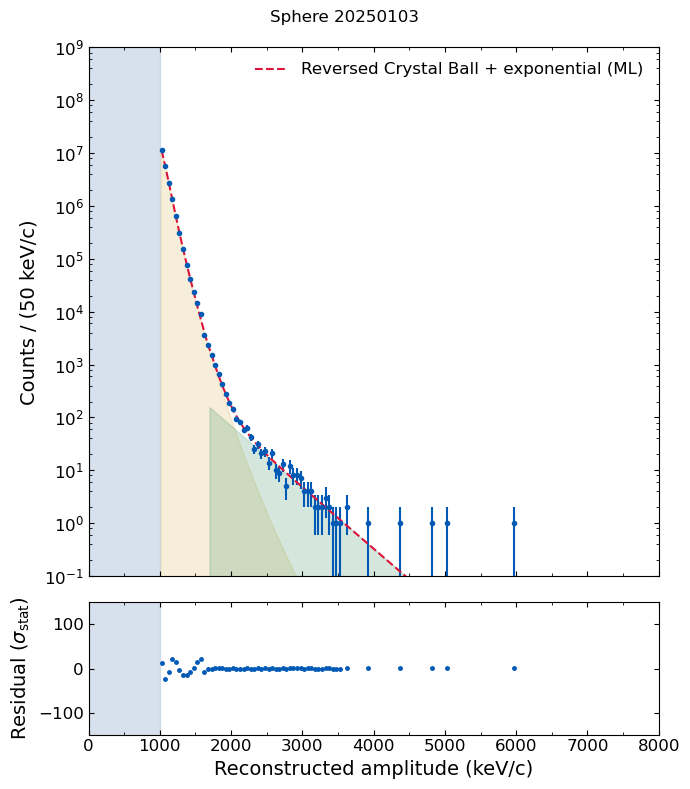

In [ ]:
ntot = np.sum(hist)
args = (bc, hist)

res = minimize(fun=lambda x: nll(*x, *args), 
               method='Nelder-Mead',
               x0 = [0.999999963, 3.88913877, 18.8311789, 164.921104, 255.466148, 1700.34007, 388.650890],
               bounds = [(0.9999, 1), (3, 4), (10, 30), (100, 200), (200, 300), (1400, 2000), (300, 500)],

               options={'disp' : True,
                        'maxiter': 10000,
                        'maxfev': 10000,
                        'adaptive': True,
                        'fatol': 0.0001,
                        }
               )

param_nodm = res.x
nll_nodm   = res.fun

print(res.x)

plot_likelihood_fit(bc, hist, res.x)